# Phase II: Testing ROS with Several Models for Comparison


In [8]:
'''
*    Text Pre-Processing    *
'''
import pandas as pd
import nltk
import re
import numpy as np
import umap.umap_ as umap
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


'''
*    Plotting    *
'''
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import umap.plot
from yellowbrick.text import FreqDistVisualizer
from wordcloud import WordCloud, ImageColorGenerator


'''
*    Training & Metrics    *
'''
import logging
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, classification_report
from scipy import interp
from itertools import cycle



'''
*    Model Selection    *
'''
import pickle
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier

In [10]:
'''import'''
df = pd.read_csv('master.csv')

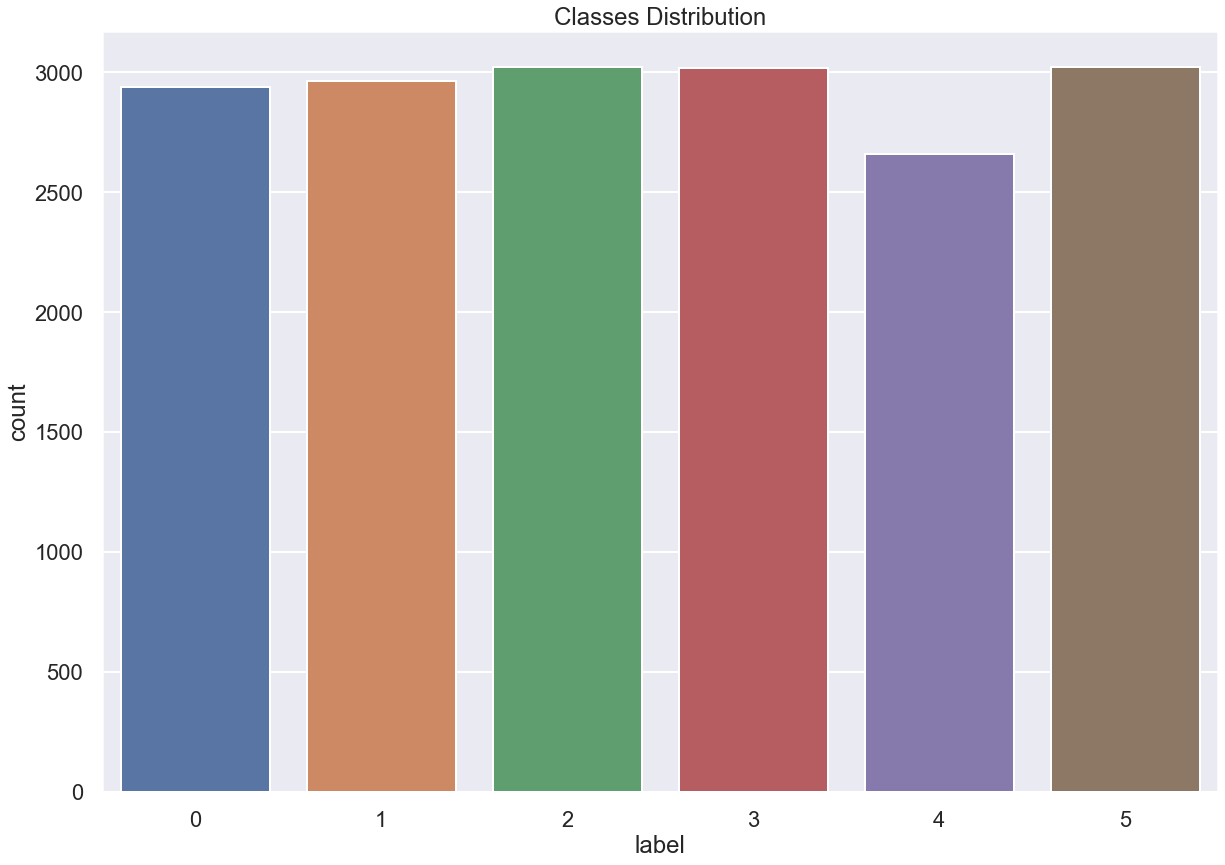

In [15]:
sns.countplot(x='label', data=df)
plt.title("Classes Distribution")
plt.savefig("Class.png", dpi=300)

In [11]:
'''defining vectorizer'''
docs = df['text'].astype(str).dropna()
vectorizer = TfidfVectorizer(stop_words='english', 
                             min_df = 5,
                             ngram_range = (1,2),
                             use_idf = True,
                             max_df = 0.5, 
                             smooth_idf=True)


'''vectorizing text, and mapping the labels'''
label_map = {0: 'Depression',
             1: 'PTSD',
             2: 'CPTSD',
             3: 'Borderline',
             4: 'Bipolar',
             5: 'Dissociation'}

X = vectorizer.fit_transform(docs).toarray()
y = df['label'].values
y_label = df['label'].map(label_map)


print(X.shape)
y.shape

(17623, 42471)


(17623,)

# Dimension Reduction - UMAP


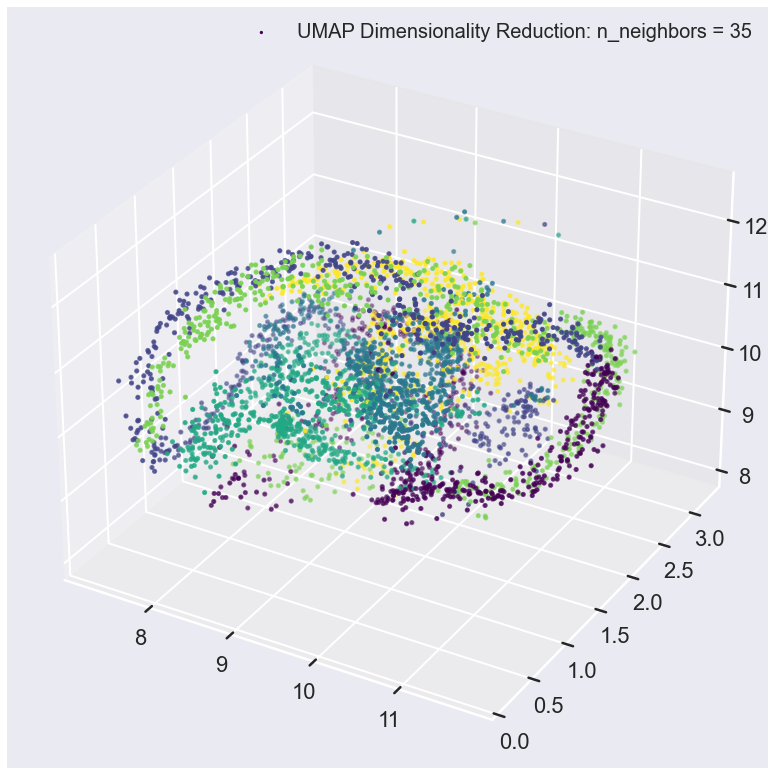

,model_name,accuracy_score,precision_score,recall_score,f1_score
3,K Nearest Neighbor,0.898418,0.899422,0.898467,0.898332
0,Random Forest,0.88343,0.883623,0.883759,0.883285
1,Decsision Tree,0.85179,0.851976,0.851752,0.85184
2,AdaBoost,0.49209,0.517792,0.491804,0.491233


In [36]:
fit = umap.UMAP(n_neighbors = 35,
                min_dist = .1,
                n_components = 3,
                metric = 'euclidean')

data_umap = fit.fit_transform(X)

sns.set(style='darkgrid', context='poster', rc={'figure.figsize':(20,14)})
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_umap[:,0], data_umap[:,1], data_umap[:,2], c=y, s=10, cmap='viridis')
leg = plt.legend(['UMAP Dimensionality Reduction: n_neighbors = 35'], loc='best', borderpad=0.3, 
                  shadow=False, prop=matplotlib.font_manager.FontProperties(size='small'), markerscale=0.4)
leg.get_frame().set_alpha(0.4)
leg.set_draggable(state=True)
plt.show()
        
model_dict = {'Random Forest': RandomForestClassifier(random_state=42),
              'Decsision Tree': DecisionTreeClassifier(random_state=42),
              'AdaBoost': AdaBoostClassifier(random_state=42),
              'K Nearest Neighbor': KNeighborsClassifier()}

#Train test split with stratified sampling for evaluation
X_train, X_test, y_train, y_test = train_test_split(data_umap, 
                                                    y, 
                                                    test_size = .3, 
                                                    shuffle = True, 
                                                    random_state = 3)

#Function to get the scores for each model in a df
def model_score_df(model_dict):   
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
    for k,v in model_dict.items():   
        model_name.append(k)
        v.fit(X_train, y_train)
        y_pred = v.predict(X_test)
        ac_score_list.append(accuracy_score(y_test, y_pred))
        p_score_list.append(precision_score(y_test, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
    return model_comparison_df

model_score_df(model_dict)



In [ ]:
#KNN
n_neighbors = [5,7,10,15]
weights = ['uniform','distance']
leaf_size = [5,10,30,50]
p = [1,2]
n_jobs = [-1]

clf = KNeighborsClassifier()

params = dict(n_neighbors = n_neighbors,
              weights = weights,
              leaf_size = leaf_size,
              p = p,
              n_jobs = n_jobs)

gridsearch = GridSearchCV(clf,
                          params, 
                          cv=5,
                          verbose=1, 
                          n_jobs=-1)

knn_best_model = gridsearch.fit(data_umap, y)

In [37]:
knn_best_model = KNeighborsClassifier(leaf_size=5,
                                      n_jobs=-1,
                                      n_neighbors=5,
                                      p =2,
                                      weights='distance')

C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


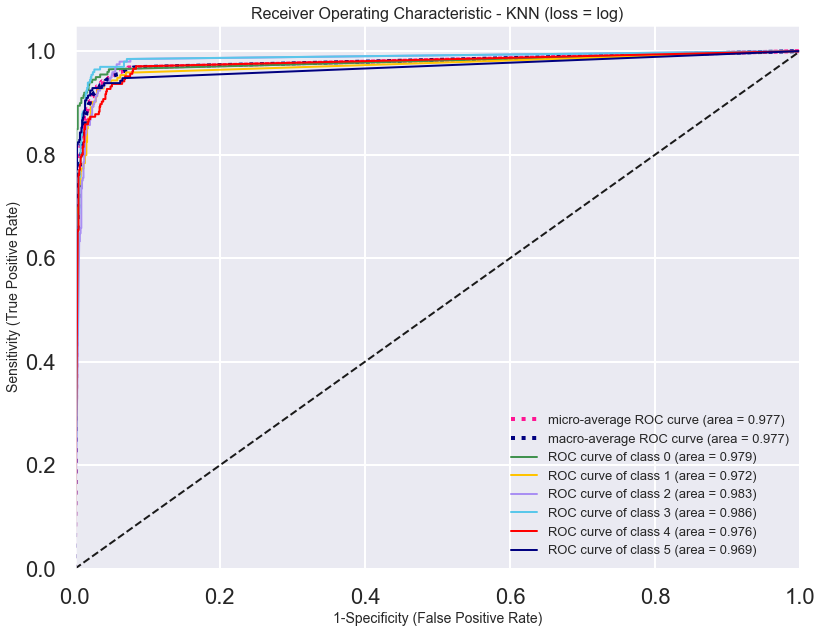

In [38]:
#Plot AUC - SGD
import numpy as np
#Binarize the labels
y_b = label_binarize(y_res_b, classes = [0, 1, 2, 3, 4, 5])
n_classes = y_b.shape[1]
#Shuffle and split training and test sets with stratified sampling and binarized labels
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(data_umap,
                                                            y_b,
                                                            test_size = .3,
                                                            shuffle = True,
                                                            random_state = 3)

#Learn to predict each class against the other
KNN_classifier = OneVsRestClassifier(knn_best_model)
y_score = KNN_classifier.fit(X_train_c, y_train_c).predict_proba(X_test_c)



#Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_c[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#Compute micro-average ROC curve and ROC area
fpr['micro'], tpr['micro'], _ = roc_curve(y_test_c.ravel(), y_score.ravel())
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

#First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

#Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

#Finally average it and compute AUC
mean_tpr /= n_classes

fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

#Plot all ROC curves
plt.figure(figsize=(13,10)) 
sns.set_style('darkgrid')
lw=2

plt.plot(fpr['micro'], 
         tpr['micro'], 
         label='micro-average ROC curve (area = {0:0.3f})'''.format(roc_auc['micro']),
         color='deeppink',
         linestyle=':', 
         linewidth=4)

plt.plot(fpr['macro'], 
         tpr['macro'], 
         label='macro-average ROC curve (area = {0:0.3f})'''.format(roc_auc['macro']),
         color='navy', 
         linestyle=':', 
         linewidth=4)

colors = cycle(['#41924F', '#FFC300', '#a98ff3', '#59C7EA', 'red', 'navy'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], 
             color=color, 
             lw=lw, 
             label='ROC curve of class {0} (area = {1:0.3f})'''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity (False Positive Rate)', fontsize = 14)
plt.ylabel('Sensitivity (True Positive Rate)', fontsize = 14)
plt.title('Receiver Operating Characteristic - KNN (loss = log)', fontsize = 16)
plt.legend(loc="lower right", fontsize = 13)
plt.show()

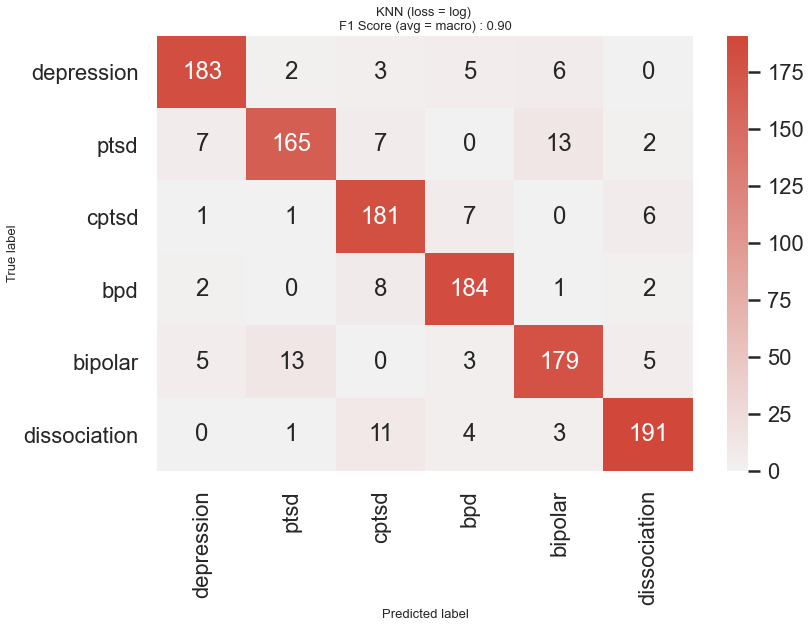

In [39]:
#Train test split with stratified sampling. Using non-binarized labels
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(data_umap, 
                                                            y_res_b, 
                                                            test_size = .3, 
                                                            shuffle = True, 
                                                            random_state = 3)
#Fit the training data
knn_best_model.fit(X_train_d, y_train_d)
y_pred = knn_best_model.predict(X_test_d)

#Get the confusion matrix and put it into a df
cm = confusion_matrix(y_test_d, y_pred) 

cm_df = pd.DataFrame(cm,
                     index = ['depression','ptsd','cptsd', 'bpd', 'bipolar', 'dissociation'], 
                     columns = ['depression','ptsd','cptsd', 'bpd', 'bipolar', 'dissociation'])

#Plot the heatmap
plt.figure(figsize=(12, 8))

sns.heatmap(cm_df, 
            center=0, 
            cmap=sns.diverging_palette(220, 15, as_cmap=True), 
            annot=True, 
            fmt='g')

plt.title('KNN (loss = log) \nF1 Score (avg = macro) : {0:.2f}'.format(f1_score(y_test_d, y_pred, average='macro')), fontsize = 13)
plt.ylabel('True label', fontsize = 13)
plt.xlabel('Predicted label', fontsize = 13)
plt.show()
